# Exercise

Let's go back to our galaxy vs quasar data we've used in a previous exercise.

* Read in SDSS galaxy color data from solutions/galaxyquasar.csv. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=0 and quasar=1.
* Now we're going to fit a neural network classifier. First, scale your data appropriately and do a $30 \%$ train/test split.
* Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning.
* Start from a network architecture with a single hidden layer with $5$ neurons, using the adam solver, the relu activation function, and a learninig rate of 0.001. Plot the resulting ROC curve.
* Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best. Do your best now to optimize the network architecture. Be creative!
* Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

A few tips:

1. In scikit-learn, remember that you can utilize all availables cores on your machine with n_jobs=-1. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
2. If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
3. On cross validation, for scikit learn we've seen how to use GridSearchCV already. For Tensorflow, there's a really cool tool called Tensorboard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
data=np.genfromtxt('/Users/beasa/Desktop/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv', 
                   delimiter=',', names=True, usecols=(0, 1, 2, 3, 4, 6), dtype=float)

In [3]:
print(data.dtype.names)
data

('u', 'g', 'r', 'i', 'z', 'z1')


array([(18.97213, 18.53676, 18.5828 , 18.34936, 18.29215, 0.5228189 ),
       (19.24592, 17.47646, 16.47817, 16.04472, 15.68851, 0.1228459 ),
       (19.43536, 17.70268, 16.91565, 16.58327, 16.39128, 0.        ),
       ...,
       (18.62718, 17.30876, 16.87371, 16.62399, 16.42296, 0.05442934),
       (19.5514 , 18.27711, 17.62101, 17.21947, 17.03347, 0.1125709 ),
       (18.80772, 17.75751, 17.405  , 17.2165 , 17.12295, 0.04365238)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('z1', '<f8')])

In [4]:
u = []
g = []
r = []
i = []
z = []
ug = []
gr = []
ri = []
iz = []

for j in range (0, len(data)):
    u.append(data[j][0])
    g.append(data[j][1])
    r.append(data[j][2])
    i.append(data[j][3])
    z.append(data[j][4])
    
    ug.append(u[j]-g[j])
    gr.append(g[j]-r[j])
    ri.append(r[j]-i[j])
    iz.append(i[j]-z[j])

In [5]:
u = np.array(u)
g = np.array(g)
r = np.array(r)
i = np.array(i)
z = np.array(z)
ug = np.array(ug)
gr = np.array(gr)
ri = np.array(ri)
iz = np.array(iz)

In [6]:
labels = np.genfromtxt('/Users/beasa/Desktop/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv', 
                       delimiter=',', skip_header=1, usecols=5, dtype=str)  # column = 5: it is the one of the labels
labels

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [7]:
newLabels = []

for k in range(0, len(labels)):
    if labels[k]=='GALAXY':
        newLabels.append(0)
    if labels[k]=='QSO':
        newLabels.append(1)

newLabels = np.array(newLabels)

To start, I split the data set into training and validation sets.

In [8]:
X = np.array([ug, gr, ri, iz]).T
y = np.copy(newLabels)

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=77)

Then, I define a model with the method $Sequential()$: the model is composed by a sequence of two hidden layers. The first one contains $5$ neurons and I use as activation function ReLU. The second one, instead, is the output layer: it is composed by $1$ neuron and I use as activation function the Sigmoid.

Consequently, I compile the model by using the Adam solver with a learning rate of $0.001$. I use 'binary_crossentropy' because I am dealing with a binary classification problem, and 'accuracy' to take into account the percentage of correct predictions during the process.

To conclude, I fit the training data with the model, I compute the predictions for the validation set and the corresponding false positive and true positive rates.

In [9]:
model = Sequential([Dense(5, activation='relu', input_shape=(X_train.shape[1], )),
    Dense(1, activation='sigmoid')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=90, batch_size=32, validation_split=0.2, verbose=0)

y_pred = model.predict(X_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_pred)




469/469 [==============================] - 1s 2ms/step


I plot the resulting ROC curve.

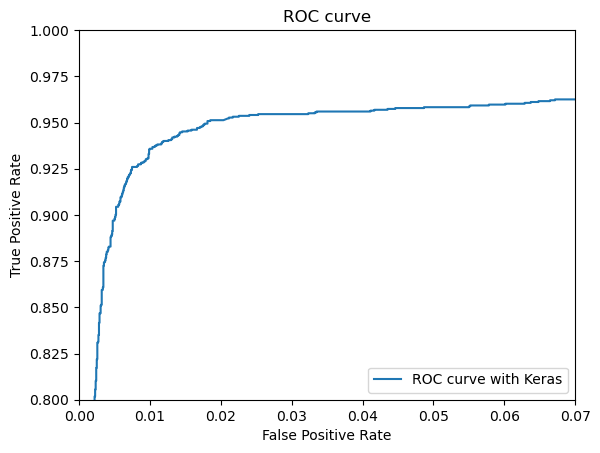

In [10]:
plt.plot(fpr, tpr, label='ROC curve with Keras')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.xlim(0, 0.07)
plt.show()

##### Optimization

I start by defining a function that creates the model by starting with some input parameters as the number of neurons, the learning rate and the number of hidden layers.

N.B.: the number of neurons in each hidden layer is the same.

In [18]:
def createModel(units, LR, HL):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1], )))
    
    for q in range(HL-1):
        model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1], )))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

I define a series of cycles $for$ to save in the array $results$ the values of $Nneurons$, $NhiddenL$, $learningRate$ and accuracy ($val\_accuracy$) for the corresponding generated model. I compute the best model as the one for which the accuracy in the highest and I print the corresponding values for the learning rate, accuracy, number of neurons and hidden layers.

In [25]:
Nneurons = [4, 5, 7]
NhiddenL = [1, 3, 5]
learningRate = [0.01, 0.001]
Nepochs = 30
batchSize = 32

results = []

for o in Nneurons:
    for lr in learningRate:
        for hl in NhiddenL:
            Model = createModel(o, lr, hl)
        
            history = model.fit(X_train, y_train, epochs=Nepochs, batch_size=batchSize, validation_split=0.2, verbose=0)
        
            val_accuracy = max(history.history['val_accuracy'])  # I want the highest accuracy
            
            results.append((o, lr, hl, val_accuracy))

best_config = max(results, key=lambda x: x[3])  # best accuracy, which is in the array at the index=3

print('Best Configuration:')
print(f'Number of neurons: {best_config[0]}')
print(f'Learning rate: {best_config[1]}')
print(f'Hidden layers: {best_config[2]}')
print(f'Accuracy: {best_config[3]:.4f}')

Best Configuration:
Number of neurons: 4
Learning rate: 0.001
Hidden layers: 5
Accuracy: 0.9867


I create the model with the best parameters and I compute the corresponding false positive and true positive rates.

In [29]:
BestModel = createModel(best_config[0], best_config[1], best_config[2])
history = BestModel.fit(X_train, y_train, epochs=90, batch_size=32, validation_split=0.2, verbose=0)

y_predB = BestModel.predict(X_val).ravel()
fprB, tprB, thresholdsB = roc_curve(y_val, y_predB)

469/469 [==============================] - 1s 2ms/step


Now, I plot the ROC curve.

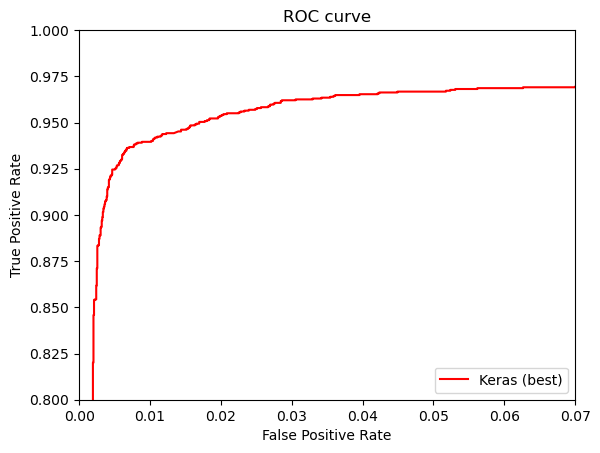

In [32]:
plt.plot(fprB, tprB, color='red', label='Keras (best)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.xlim(0, 0.07)
plt.show()

And I graphically compare the results for the first model with the optimized one.

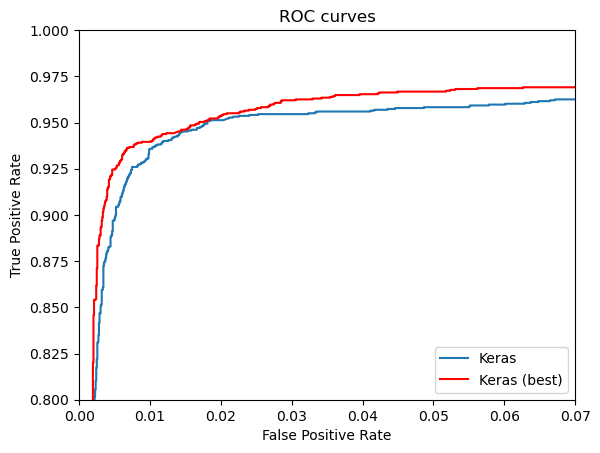

In [33]:
plt.plot(fpr, tpr, label='Keras')
plt.plot(fprB, tprB, color='red', label='Keras (best)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.xlim(0, 0.07)
plt.show()